In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf

In [6]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import isnan, when, count, col, udf, explode

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

In [8]:
sc = SparkContext(master='local', appName='Recommendation_System')

In [9]:
spark = SparkSession(sc)

In [10]:
data = spark.read.option("multiLine", True).csv("ReviewRaw.csv", header=True, inferSchema=True)

In [11]:
data.show(5,truncate=True)

+-----------+----------+-----------------+----------------+-------------------+------+------------------+--------------------+
|customer_id|product_id|             name|       full_name|       created_time|rating|             title|             content|
+-----------+----------+-----------------+----------------+-------------------+------+------------------+--------------------+
|     709310|  10001012| Lân Nguyễn Hoàng|Lân Nguyễn Hoàng|               null|     3|Ko dùng đc thẻ nhớ|Lúcđầu quên thông...|
|   10701688|  10001012| Nguyễn Khánh Hòa|Nguyễn Khánh Hòa|               null|     5|   Cực kì hài lòng|Tiki giao hàng nh...|
|   11763074|  10001012|  Toàn Phạm Khánh| Toàn Phạm Khánh|2019-04-17 15:42:45|     5|   Cực kì hài lòng|chất lượng camera...|
|    9909549|  10001012|Nguyen Quang Minh|            null|               null|     5|      Rất hài lòng|Hàng được đóng gó...|
|    1827148|  10001012|      Phạm Bá Đức|     Phạm Bá Đức|               null|     5|   Cực kì hài lòng|dễ cài

In [12]:
data.describe().show()

+-------+-----------------+--------------------+----------------+----------------+------------------+--------------------+--------------------+
|summary|      customer_id|          product_id|            name|       full_name|            rating|               title|             content|
+-------+-----------------+--------------------+----------------+----------------+------------------+--------------------+--------------------+
|  count|           364089|              364089|          363659|          329461|            364089|              364060|              165784|
|   mean| 9174382.00025818|2.4444598198426757E7|            null|            null| 4.477303626311149|2.1590980633333334E8|6.734006734006735...|
| stddev|6308902.054928042|2.3787283561655413E7|            null|            null|1.0146510538612634|4.2845719456187785E8|2.608069593405668...|
|    min|               10|               54665|\bLại Mạnh Cường|\bLại Mạnh Cường|                 1|          \bHài lòng|\bLâu lâu mỗi 

In [13]:
data.groupBy('rating').agg({'rating': 'count'}).orderBy('count(rating)', ascending=False).show()

+------+-------------+
|rating|count(rating)|
+------+-------------+
|     5|       258690|
|     4|        60924|
|     3|        20698|
|     1|        16657|
|     2|         7120|
+------+-------------+



There are many products rated 5 stars

In [14]:
result = data.groupBy('product_id').agg({'rating': 'count'}).orderBy('count(rating)', ascending=False)
pandas_result = result.toPandas().head(10)

pandas_result['product_id'] = pandas_result['product_id'].astype(str)

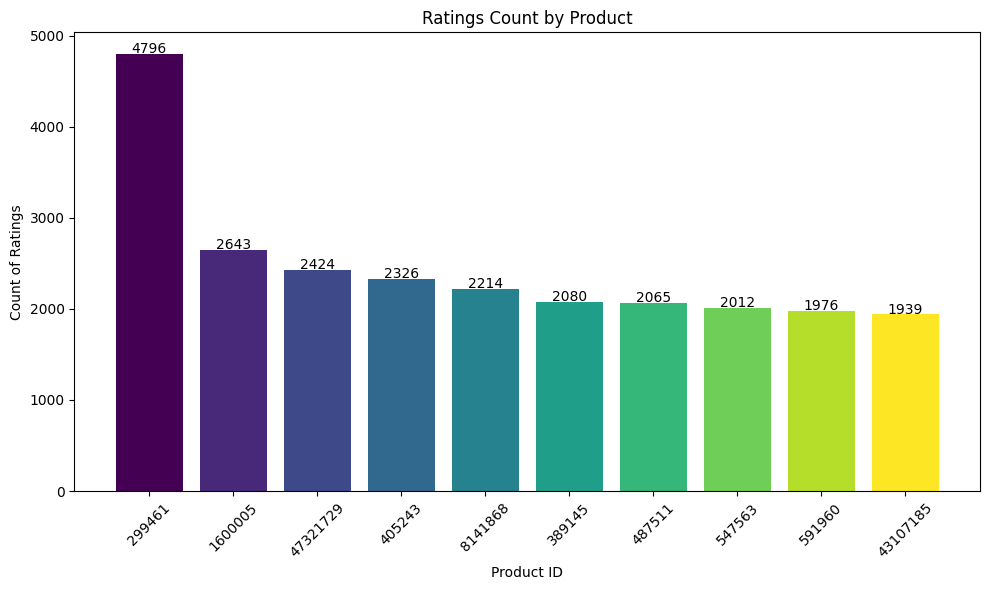

In [24]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(pandas_result)))

for idx, row in pandas_result.iterrows():
    plt.bar(row['product_id'], row['count(rating)'], color=colors[idx], label=row['product_id'])
    plt.text(row['product_id'], row['count(rating)'] + 10, str(row['count(rating)']), ha='center')

plt.xlabel('Product ID')
plt.ylabel('Count of Ratings')
plt.title('Ratings Count by Product')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
product = spark.read.option("multiLine", True).csv("ProductRaw.csv", header=True, inferSchema=True)

In [28]:
product.show(5,truncate=True)

+--------+--------------------+--------------------+------+-------+----------+--------+--------------------+--------------------+--------------------+
| item_id|                name|         description|rating|  price|list_price|   brand|               group|                 url|               image|
+--------+--------------------+--------------------+------+-------+----------+--------+--------------------+--------------------+--------------------+
|48102821|Tai nghe Bluetoot...|THÔNG TIN CHI TIẾ...|   4.0|  77000|    300000|     OEM|Thiết Bị Số - Phụ...|https://tai-nghe-...|https://salt.tiki...|
|52333193|Tai nghe bluetoot...|THÔNG TIN CHI TIẾ...|   4.5| 132000|    750000|     OEM|Thiết Bị Số - Phụ...|https://tai-nghe-...|https://salt.tiki...|
|  299461|Chuột Không Dây L...|THÔNG TIN CHI TIẾ...|   4.8| 299000|    399000|Logitech|Thiết Bị Số - Phụ...|https://chuot-kho...|https://salt.tiki...|
|57440329|Loa Bluetooth 5.0...|THÔNG TIN CHI TIẾ...|   4.7| 149000|    350000|   Acome|Thiết B

In [32]:
# Products with the most reviews
for i in pandas_result['product_id']:
  product.filter(col('item_id') == int(i)).select('name').show(truncate=False)

+------------------------------------------------------+
|name                                                  |
+------------------------------------------------------+
|Chuột Không Dây Logitech M331 Silent - Hàng Chính Hãng|
+------------------------------------------------------+

+------------------------------------------------------------+
|name                                                        |
+------------------------------------------------------------+
|Tai Nghe Nhét Tai Mi Basic Xiaomi HSEJ03JY - Hàng Chính Hãng|
+------------------------------------------------------------+

+--------------------------------------------------------------------------------------------------------------------+
|name                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------+
|Pin Sạc Dự Phòng Xiaomi Redmi 20000mAh P

The most reviewed product is Logitech M331 Silent Wireless Mouse with 4796 reviews. These may be products that Tiki wants to boost sales so it has created many reviews. It may also be products that many people buy and are interested in so it has received many reviews from customers who have purchased the products.

In [36]:
result1 = data.groupBy('customer_id').agg({'rating': 'count'}).orderBy('count(rating)', ascending=False)
pandas_result1 = result1.toPandas().head(10)

pandas_result1['customer_id'] = pandas_result1['customer_id'].astype(str)

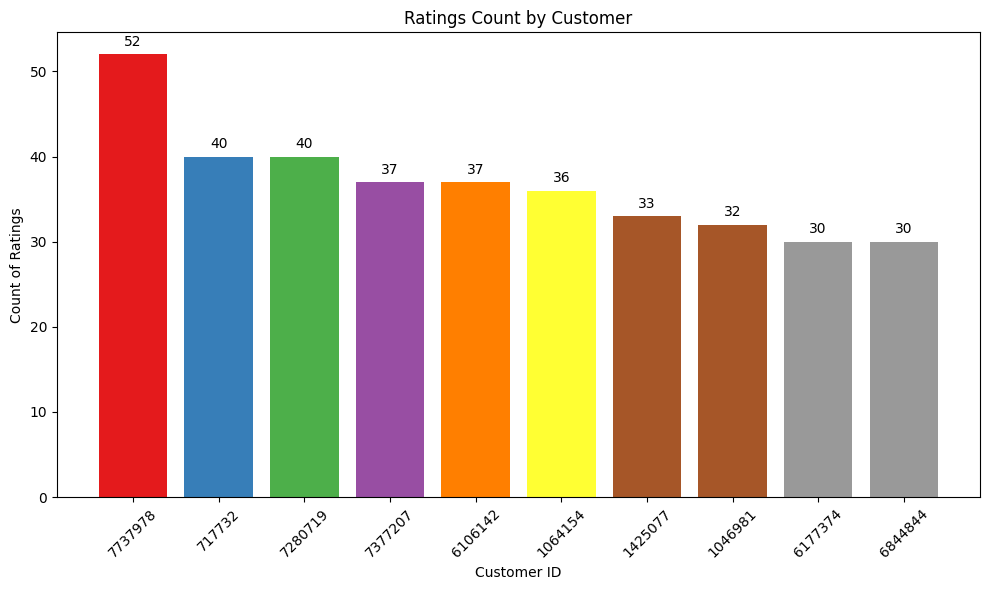

In [38]:
plt.figure(figsize=(10, 6))
colors = plt.cm.Set1(np.linspace(0, 1, len(pandas_result1)))

for idx, row in pandas_result1.iterrows():
    plt.bar(row['customer_id'], row['count(rating)'], color=colors[idx], label=row['customer_id'])
    plt.text(row['customer_id'], row['count(rating)'] + 1, str(row['count(rating)']), ha='center')

plt.xlabel('Customer ID')
plt.ylabel('Count of Ratings')
plt.title('Ratings Count by Customer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
data.filter(col('customer_id') == 7737978).select('name').show(1,truncate=False)

+-----------+
|name       |
+-----------+
|Đỗ Thanh Hy|
+-----------+
only showing top 1 row



Customer Do Thanh Hy has rated the most, having rated 52 products

In [41]:
data_sub = data.select(['product_id', 'rating', 'customer_id'])

In [42]:
data_sub.count()

364089

In [43]:
data_sub.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- customer_id: integer (nullable = true)



In [44]:
data_sub.show(5, truncate=True)

+----------+------+-----------+
|product_id|rating|customer_id|
+----------+------+-----------+
|  10001012|     3|     709310|
|  10001012|     5|   10701688|
|  10001012|     5|   11763074|
|  10001012|     5|    9909549|
|  10001012|     5|    1827148|
+----------+------+-----------+
only showing top 5 rows



In [45]:
# Check null rows
data_sub.select([count(when(col(c).isNull(), c)).alias(c) for c in
           data_sub.columns]).toPandas().T

,0
product_id,0
rating,0
customer_id,0


In [46]:
# Check duplicate rows
print('Number of duplicated records:',data_sub.count() - data_sub.dropDuplicates().count())

Number of duplicated records: 3888


The data is not null but there are 3888 duplicate rows

In [47]:
# remove duplicated rows
data_sub = data_sub.dropDuplicates()
data_sub.count()

360201

In [48]:
# Distinct users and products
users = data_sub.select("customer_id").distinct().count()
products = data_sub.select("product_id").distinct().count()
numerator = data_sub.count()

In [49]:
display(numerator, users, products)

360201

251485

4218

In [50]:
# Number of ratings matrix could contain if no empty cells
denominator = users * products
denominator

1060763730

In [51]:
# Calculating sparsity
sparsity = 1 - (numerator*1.0 / denominator)
print ("Sparsity: "), sparsity

Sparsity: 


(None, 0.9996604323943089)

In [52]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [53]:
# Converting String to index
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [54]:
# Smaller dataset so we will use 0.7 / 0.3
(training, test) = data_sub.randomSplit([0.7, 0.3])

In [61]:
als = ALS(maxIter=15,
          regParam=0.5,
          rank=25,
          userCol='customer_id',
          itemCol='product_id',
          ratingCol='rating',
          coldStartStrategy='drop',
          nonnegative=True)
model = als.fit(training)

In [62]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)

In [63]:
predictions.show(5)

+----------+------+-----------+----------+
|product_id|rating|customer_id|prediction|
+----------+------+-----------+----------+
|    227404|     5|        158| 4.4148016|
|  17038778|     5|        158| 4.1036067|
|  19336345|     5|        158|  4.348578|
|  25078249|     4|        158| 4.5411677|
|  58251883|     4|        167| 4.3362613|
+----------+------+-----------+----------+
only showing top 5 rows



In [64]:
evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)

In [65]:
print('Root-mean-squared-error = ' +str(rmse))

Root-mean-squared-error = 1.1439624553996561


In [60]:
data_sub.agg({'rating':'min'}).show()
data_sub.agg({'rating':'max'}).show()

+-----------+
|min(rating)|
+-----------+
|          1|
+-----------+

+-----------+
|max(rating)|
+-----------+
|          5|
+-----------+



Rating is from 1-5 so rmse = 1.14 (< 1.2) is appropriate

### Providing Recommendations: for all users

In [66]:
# get 5 recommendations which have highest rating
user_recs = model.recommendForAllUsers(5)

In [67]:
user_recs.show(10, truncate=False)

+-----------+------------------------------------------------------------------------------------------------------------------+
|customer_id|recommendations                                                                                                   |
+-----------+------------------------------------------------------------------------------------------------------------------+
|10         |[{66251373, 4.817477}, {76732229, 4.5687985}, {71293311, 4.469165}, {73844240, 4.407162}, {15287960, 4.3696485}]  |
|27         |[{66251373, 5.336712}, {76732229, 5.0572157}, {71293311, 4.922597}, {73844240, 4.87033}, {29425483, 4.805385}]    |
|28         |[{66251373, 5.344054}, {76732229, 5.0842113}, {71293311, 4.943311}, {73844240, 4.913754}, {29425483, 4.8894453}]  |
|50         |[{66251373, 4.8340845}, {76732229, 4.5832005}, {71293311, 4.4648786}, {29425483, 4.4235272}, {73844240, 4.402413}]|
|51         |[{66251373, 5.317039}, {76732229, 5.043587}, {71293311, 4.9250717}, {73844240, 4.872

In [68]:
user_recs.count()

190399

In [69]:
for user in user_recs.head(5):
  print(user)
  print('\n')

Row(customer_id=10, recommendations=[Row(product_id=66251373, rating=4.817477226257324), Row(product_id=76732229, rating=4.568798542022705), Row(product_id=71293311, rating=4.469164848327637), Row(product_id=73844240, rating=4.407162189483643), Row(product_id=15287960, rating=4.369648456573486)])


Row(customer_id=27, recommendations=[Row(product_id=66251373, rating=5.336711883544922), Row(product_id=76732229, rating=5.057215690612793), Row(product_id=71293311, rating=4.9225969314575195), Row(product_id=73844240, rating=4.870329856872559), Row(product_id=29425483, rating=4.805385112762451)])


Row(customer_id=28, recommendations=[Row(product_id=66251373, rating=5.344054222106934), Row(product_id=76732229, rating=5.084211349487305), Row(product_id=71293311, rating=4.9433112144470215), Row(product_id=73844240, rating=4.913753986358643), Row(product_id=29425483, rating=4.8894453048706055)])


Row(customer_id=50, recommendations=[Row(product_id=66251373, rating=4.834084510803223), Row(prod

In [93]:
result = user_recs.select(user_recs.customer_id, explode(user_recs.recommendations))
result = result.withColumn('product_id', result.col.getField('product_id'))\
                .withColumn('rating', result.col.getField('rating'))
result.show()

+-----------+--------------------+----------+---------+
|customer_id|                 col|product_id|   rating|
+-----------+--------------------+----------+---------+
|         10|{66251373, 4.817477}|  66251373| 4.817477|
|         10|{76732229, 4.5687...|  76732229|4.5687985|
|         10|{71293311, 4.469165}|  71293311| 4.469165|
|         10|{73844240, 4.407162}|  73844240| 4.407162|
|         10|{15287960, 4.3696...|  15287960|4.3696485|
|         27|{66251373, 5.336712}|  66251373| 5.336712|
|         27|{76732229, 5.0572...|  76732229|5.0572157|
|         27|{71293311, 4.922597}|  71293311| 4.922597|
|         27| {73844240, 4.87033}|  73844240|  4.87033|
|         27|{29425483, 4.805385}|  29425483| 4.805385|
|         28|{66251373, 5.344054}|  66251373| 5.344054|
|         28|{76732229, 5.0842...|  76732229|5.0842113|
|         28|{71293311, 4.943311}|  71293311| 4.943311|
|         28|{73844240, 4.913754}|  73844240| 4.913754|
|         28|{29425483, 4.8894...|  29425483|4.8

In [94]:
result.write.json('result.json')

In [95]:
all_result = spark.read.json('result.json')

In [96]:
all_result.show()

+--------------------+-----------+----------+---------+
|                 col|customer_id|product_id|   rating|
+--------------------+-----------+----------+---------+
|{66251373, 4.817477}|         10|  66251373| 4.817477|
|{76732229, 4.5687...|         10|  76732229|4.5687985|
|{71293311, 4.469165}|         10|  71293311| 4.469165|
|{73844240, 4.407162}|         10|  73844240| 4.407162|
|{15287960, 4.3696...|         10|  15287960|4.3696485|
|{66251373, 5.336712}|         27|  66251373| 5.336712|
|{76732229, 5.0572...|         27|  76732229|5.0572157|
|{71293311, 4.922597}|         27|  71293311| 4.922597|
| {73844240, 4.87033}|         27|  73844240|  4.87033|
|{29425483, 4.805385}|         27|  29425483| 4.805385|
|{66251373, 5.344054}|         28|  66251373| 5.344054|
|{76732229, 5.0842...|         28|  76732229|5.0842113|
|{71293311, 4.943311}|         28|  71293311| 4.943311|
|{73844240, 4.913754}|         28|  73844240| 4.913754|
|{29425483, 4.8894...|         28|  29425483|4.8

In [97]:
def get_user_recommendations(customer_id):
    find_user_rec = all_result.filter(col('customer_id') == customer_id)
    find_user_rec = find_user_rec.drop('col')
    return find_user_rec

In [98]:
customer_id=50
start_time = datetime.now()
result = get_user_recommendations(customer_id)
result.show()
end_time = datetime.now()

+-----------+----------+---------+
|customer_id|product_id|   rating|
+-----------+----------+---------+
|         50|  66251373|4.8340845|
|         50|  76732229|4.5832005|
|         50|  71293311|4.4648786|
|         50|  29425483|4.4235272|
|         50|  73844240| 4.402413|
+-----------+----------+---------+



In [99]:
print('Time token:', end_time-start_time)

Time token: 0:00:04.065202


Filter from the result file has been saved as json, the running time of the proposed result has been significantly improved

In [100]:
# Some products are suggested for customer_id=50
result_alias = result.alias("r")
product_alias = product.alias("p")

result = result_alias.join(product_alias, result_alias["product_id"] == product_alias["item_id"], how='left')
result.show()


+-----------+----------+---------+--------+--------------------+--------------------+------+-------+----------+-----------+--------------------+--------------------+--------------------+
|customer_id|product_id|   rating| item_id|                name|         description|rating|  price|list_price|      brand|               group|                 url|               image|
+-----------+----------+---------+--------+--------------------+--------------------+------+-------+----------+-----------+--------------------+--------------------+--------------------+
|         50|  29425483|4.4235272|29425483|Điện thoại IP Gra...|THÔNG TIN CHI TIẾ...|   4.5|1050000|   1700000|Grandstream|Điện Thoại - Máy ...|https://dien-thoa...|https://salt.tiki...|
|         50|  66251373|4.8340845|66251373|Flycam Bugs 20 EI...|THÔNG TIN CHI TIẾ...|   4.5|3450000|   4000000|        MJX|Máy Ảnh - Máy Qua...|https://flycam-bu...|https://salt.tiki...|
|         50|  71293311|4.4648786|71293311|Trọn bộ Camera Ip...|T

In [101]:
customer50 = data_sub.filter(col('customer_id') == 50)

In [102]:
# Some products were reviewed by customer_id=50
customer50_new = customer50.join(product, customer50["product_id"] == product["item_id"], how='inner')
customer50_new.show()

+----------+------+-----------+--------+--------------------+--------------------+------+-------+----------+-----+--------------------+--------------------+--------------------+
|product_id|rating|customer_id| item_id|                name|         description|rating|  price|list_price|brand|               group|                 url|               image|
+----------+------+-----------+--------+--------------------+--------------------+------+-------+----------+-----+--------------------+--------------------+--------------------+
|    964243|     5|         50|  964243|Ổ Cứng SSD WD Gre...|THÔNG TIN CHI TIẾ...|   4.7| 825000|   1000000|   WD|Laptop - Máy Vi T...|https://o-cung-ss...|https://salt.tiki...|
|  35580965|     4|         50|35580965|Loa thanh soundba...|THÔNG TIN CHI TIẾ...|   4.8|1799000|   3390000|   LG|Điện Tử - Điện Lạ...|https://loa-thanh...|https://salt.tiki...|
+----------+------+-----------+--------+--------------------+--------------------+------+-------+----------+--

Customer_id = 50 rated SSD hard drive and speaker with 5 stars. However, the system continues to recommend products in the Electronics, Phone, Camera, and Laptop groups to this user.

#### Compare with other customers:
These customers bought 2 products similar to customer_id = 50 and also rated 5 stars for those 2 products. 

In [104]:
customer1499 = data.filter(col('customer_id') == 1499390)
customer1499_new = customer1499.join(product, customer1499["product_id"] == product["item_id"], how='inner')
customer1499_new.show()

+-----------+----------+-------+---------+-------------------+------+---------------+-------+--------+--------------------+--------------------+------+-------+----------+-------+--------------------+--------------------+--------------------+
|customer_id|product_id|   name|full_name|       created_time|rating|          title|content| item_id|                name|         description|rating|  price|list_price|  brand|               group|                 url|               image|
+-----------+----------+-------+---------+-------------------+------+---------------+-------+--------+--------------------+--------------------+------+-------+----------+-------+--------------------+--------------------+--------------------+
|    1499390|    455445|Lý Trần|  Lý Trần|               null|     5|Cực kì hài lòng|   null|  455445|Bộ Kích Sóng Wifi...|THÔNG TIN CHI TIẾ...|   4.3| 230000|    429000|TP-Link|Laptop - Máy Vi T...|https://bo-kich-s...|https://salt.tiki...|
|    1499390|    964243|Lý Trần|

In [105]:
customer1112 = data.filter(col('customer_id') == 11123697)
customer1112_new = customer1112.join(product, customer1112["product_id"] == product["item_id"], how='inner')
customer1112_new.show()

+-----------+----------+-------------------+-------------------+-------------------+------+---------------+--------------------+--------+--------------------+--------------------+------+-------+----------+-----------+--------------------+--------------------+--------------------+
|customer_id|product_id|               name|          full_name|       created_time|rating|          title|             content| item_id|                name|         description|rating|  price|list_price|      brand|               group|                 url|               image|
+-----------+----------+-------------------+-------------------+-------------------+------+---------------+--------------------+--------+--------------------+--------------------+------+-------+----------+-----------+--------------------+--------------------+--------------------+
|   11123697|    646020|        Phạm Nguyên|        Phạm Nguyên|2019-03-03 15:59:44|     5|Cực kì hài lòng|             dùng ok|  646020|Bàn Phím Có Dây D...

When comparing the system's recommendations for customer_id = 50 with the products purchased by users who have also rated SSD hard drive and speaker with 5 stars, there are no matching products.

### Conclusion
#### The ReviewRaw dataset comprises 364,089 reviews, including 3,888 duplicates, with ratings ranging from 1 to 5. We implemented product recommendations using ALS:
The algorithm is fast and efficient, with an RMSE of approximately 1.14, which is below the threshold of 1.2.
However, when comparing customer recommendations with each other, we found inconsistencies in the algorithm's suggestions.
#### => As a result, it's essential to closely examine the accuracy of the algorithm.